# **SE4050 - Deep Learning Assignment**

IT21197246- Abeykoon A.M.Y.V.B

MODEL - Tabnet

In [80]:
# Import necessary libraries

!pip install pandas scikit-learn matplotlib seaborn
!pip install pytorch-tabnet
!pip install optuna

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [18]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

In [19]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Assignment_V1/insurance_claims.csv')

In [20]:
# Drop irrelevant columns

irrelevant_cols = ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip', '_c39']
data = data.drop(columns=irrelevant_cols)

In [21]:
# Handle missing values (replace '?' with NaN for imputation)

data.replace('?', pd.NA, inplace=True)

In [22]:
# Display the first few rows of the loaded dataset

print("Loaded dataset:")
display(data.head())

Loaded dataset:


,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,<NA>,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [23]:
# Identify numerical and categorical columns

numerical_cols = ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
                  'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'incident_hour_of_the_day']

categorical_cols = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies',
                    'insured_relationship', 'incident_type', 'collision_type', 'incident_severity',
                    'authorities_contacted', 'incident_state', 'incident_city', 'property_damage',
                    'police_report_available', 'auto_make', 'auto_model', 'auto_year']

# Print the number of numerical and categorical columns

print(f"Numerical Columns: {len(numerical_cols)}")
print(f"Categorical Columns: {len(categorical_cols)}")

Numerical Columns: 10
Categorical Columns: 18


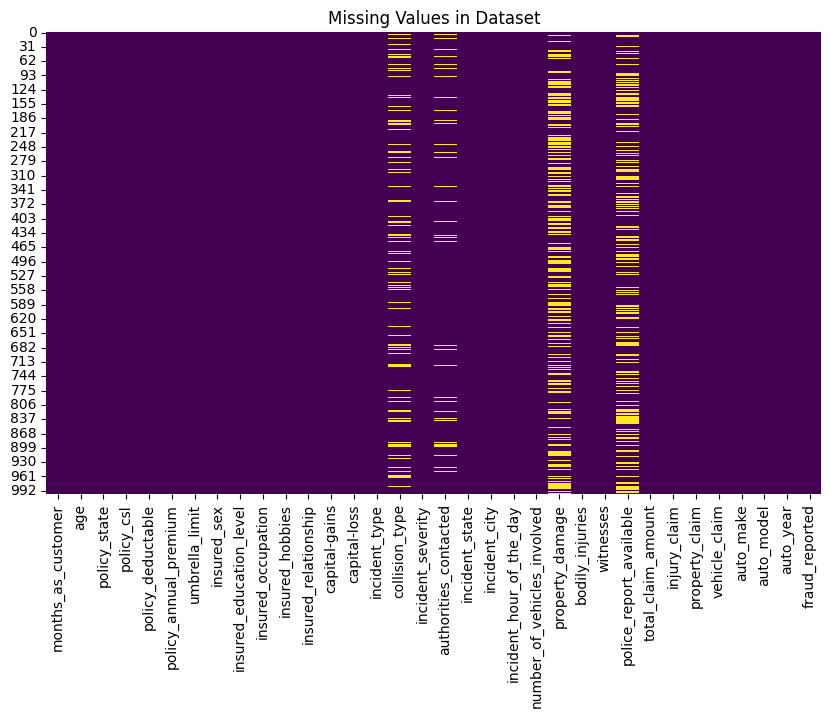

In [24]:
# Visualize missing values using a heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title('Missing Values in Dataset')
plt.show()

In [25]:
# Impute missing numerical values with mean and categorical with mode

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols].astype(str))

# Print missing values count after imputation

print("Missing values after imputation:\n", data.isnull().sum().sum())

Missing values after imputation:
 0


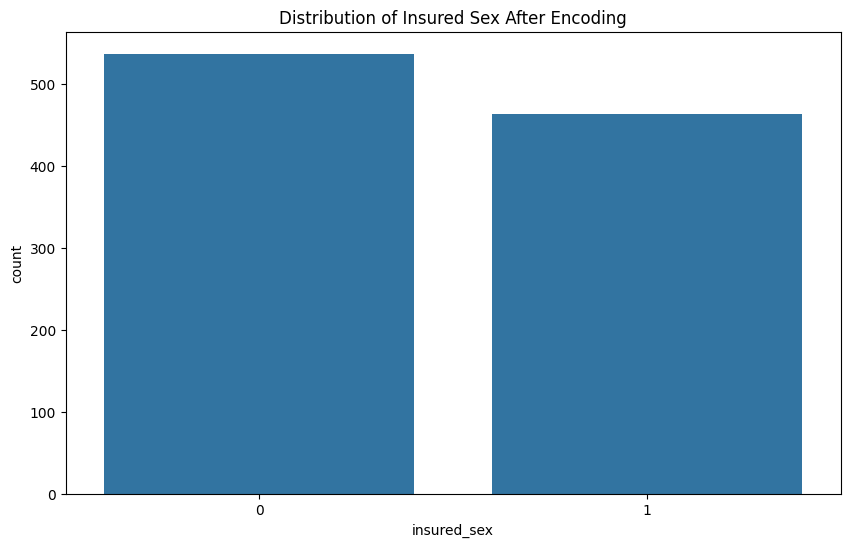

In [26]:
# Encode categorical features using LabelEncoder

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Visualize the distribution of one of the encoded categorical features

plt.figure(figsize=(10, 6))
sns.countplot(x=data['insured_sex'])
plt.title('Distribution of Insured Sex After Encoding')
plt.show()

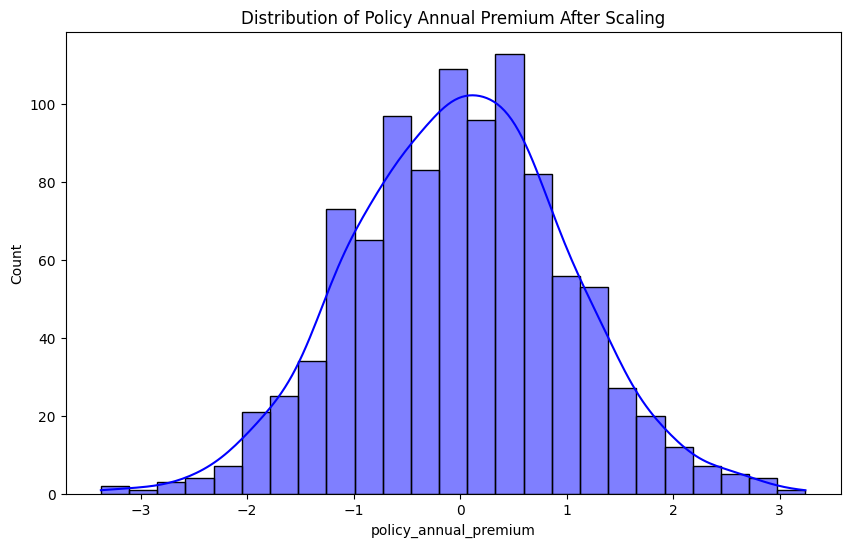

In [27]:
# Scale numerical features

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Visualize the distribution of one of the scaled numerical features

plt.figure(figsize=(10, 6))
sns.histplot(data['policy_annual_premium'], kde=True, color="blue")
plt.title('Distribution of Policy Annual Premium After Scaling')
plt.show()

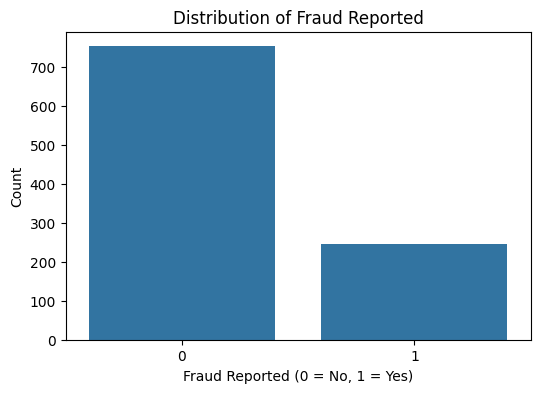

In [28]:
# Convert target column 'fraud_reported' to binary (1 for Y, 0 for N)

data['fraud_reported'] = data['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

# Visualize the distribution of the target variable

plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_reported', data=data)
plt.title("Distribution of Fraud Reported")
plt.xlabel("Fraud Reported (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [44]:
# Split the dataset into features (X) and target (y)

X = data.drop(columns=['fraud_reported'])
y = data['fraud_reported']

In [90]:
# Split into training and testing sets (80% training, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 33)
Testing set shape: (200, 33)


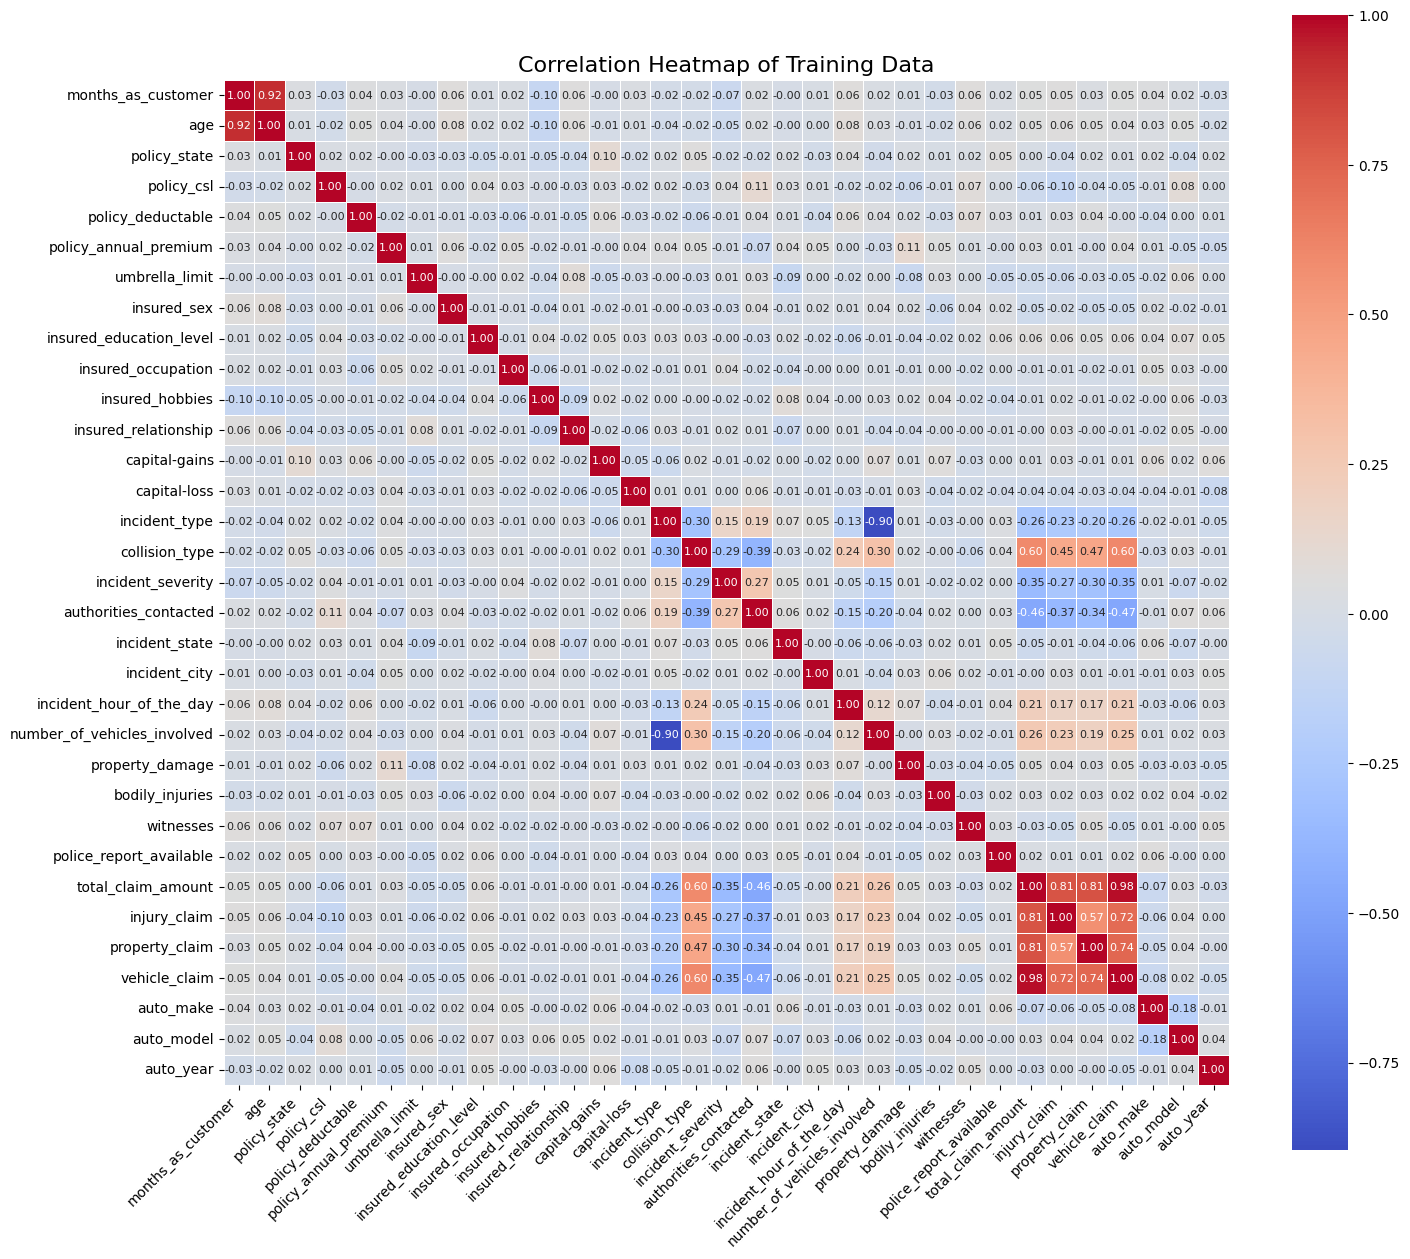

In [60]:
# Visualize the correlation heatmap of the processed training data

plt.figure(figsize=(15, 15))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Heatmap of Training Data", fontsize=16)
plt.tight_layout()

# Display the plot
plt.show()


In [61]:
# Display the processed training data sample

print("Processed Training Data Sample:")
print(X_train.head())

Processed Training Data Sample:
     months_as_customer       age  policy_state  policy_csl  \
29             0.321983  0.662455             0           2   
535           -1.207712 -1.745676             2           1   
695            0.739173  0.662455             2           1   
557           -1.225095 -1.417295             0           2   
836            0.461047  0.443534             1           0   

     policy_deductable  policy_annual_premium  umbrella_limit  insured_sex  \
29            1.412784              -0.622451       -0.479476            0   
535          -0.222383              -0.641095       -0.479476            0   
695           1.412784              -0.143400       -0.479476            0   
557          -1.039966               0.998314        2.133471            1   
836          -0.222383              -1.153746       -0.479476            0   

     insured_education_level  insured_occupation  ...  bodily_injuries  \
29                         6                  

# **Modal Architecture**

In [120]:
# Split into training and testing sets (80% training, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 33)
Testing set shape: (200, 33)


In [110]:
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_final = X_train_final.values
X_val = X_val.values
y_train_final = y_train_final.values
y_val = y_val.values

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to be tuned
    n_d = trial.suggest_int('n_d', 8, 64)
    n_a = trial.suggest_int('n_a', 8, 64)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_int('batch_size', 128, 512)

    # Define the TabNet model with suggested hyperparameters
    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type='sparsemax',  # sparsemax or entmax
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        verbose=0
    )

    # Train the model
    model.fit(
        X_train_final, y_train_final,
        eval_set=[(X_val, y_val)],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=40,  # Fixed number of epochs for tuning
        patience=0,  # No early stopping
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=True
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    # Return the accuracy as the optimization objective
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f'Best trial: {study.best_trial.params}')

[I 2024-10-06 15:07:20,407] A new study created in memory with name: no-name-f295f54f-2ac1-4090-8524-b1a12db3fbc7
<ipython-input-110-030f32c8f77d>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
[I 2024-10-06 15:07:33,054] Trial 0 finished with value: 0.6375 and parameters: {'n_d': 57, 'n_a': 22, 'n_steps': 8, 'gamma': 1.1912622447478989, 'lr': 0.01129825902636653, 'batch_size': 450}. Best is trial 0 with value: 0.6375.
<ipython-input-110-030f32c8f77d>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

Best trial: {'n_d': 50, 'n_a': 25, 'n_steps': 6, 'gamma': 1.1170029224080684, 'lr': 0.0462716832335626, 'batch_size': 132}


In [112]:
# Use the best parameters found by Optuna to train a final model
best_params = study.best_trial.params

# Train the final model with the best hyperparameters
model = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params['lr']),
    mask_type='sparsemax',
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    eval_metric=['accuracy', 'logloss'],
    max_epochs=40,
    patience=0,
    batch_size=best_params['batch_size'],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.93025 | val_0_accuracy: 0.61875 | val_0_logloss: 4.40878 |  0:00:00s
epoch 1  | loss: 1.11547 | val_0_accuracy: 0.71875 | val_0_logloss: 3.685   |  0:00:00s
epoch 2  | loss: 0.77195 | val_0_accuracy: 0.70625 | val_0_logloss: 2.98209 |  0:00:00s
epoch 3  | loss: 0.61405 | val_0_accuracy: 0.7125  | val_0_logloss: 1.95503 |  0:00:01s
epoch 4  | loss: 0.51947 | val_0_accuracy: 0.68125 | val_0_logloss: 1.13349 |  0:00:01s
epoch 5  | loss: 0.52698 | val_0_accuracy: 0.7     | val_0_logloss: 1.19771 |  0:00:01s
epoch 6  | loss: 0.49821 | val_0_accuracy: 0.5375  | val_0_logloss: 1.29673 |  0:00:02s
epoch 7  | loss: 0.55728 | val_0_accuracy: 0.725   | val_0_logloss: 1.13752 |  0:00:02s
epoch 8  | loss: 0.52865 | val_0_accuracy: 0.71875 | val_0_logloss: 0.84807 |  0:00:02s
epoch 9  | loss: 0.49399 | val_0_accuracy: 0.70625 | val_0_logloss: 0.74772 |  0:00:03s
epoch 10 | loss: 0.48748 | val_0_accuracy: 0.71875 | val_0_logloss: 1.11619 |  0:00:03s
epoch 11 | loss: 0.49094 | val_0

In [115]:
# Section 3: Evaluation

# Ensure X_test and y_test are NumPy arrays
X_test = X_test.values
y_test = y_test.values

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optional: print the classification report for detailed metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test Accuracy: 74.50%
              precision    recall  f1-score   support

           0       0.76      0.96      0.84       145
           1       0.62      0.18      0.28        55

    accuracy                           0.74       200
   macro avg       0.69      0.57      0.56       200
weighted avg       0.72      0.74      0.69       200



# **Training Loss & Validation Loss**

In [118]:
print(model.history)

{'loss': [1.9302451565861702, 1.115467680990696, 0.7719543982297182, 0.6140464626252651, 0.5194731058552862, 0.5269817290827632, 0.4982066906988621, 0.5572832528501749, 0.5286520386114717, 0.49399155247956517, 0.4874784654006362, 0.49093708880245684, 0.46082062236964705, 0.43973048981279134, 0.4577699415385723, 0.4342588117346168, 0.43696385975927116, 0.4358877016231418, 0.43509565144777296, 0.42218213733285664, 0.4270354690030217, 0.42175348326563833, 0.42757409904152155, 0.41396392732858656, 0.4115632647648454, 0.4112817462533712, 0.40427075829356907, 0.42931628227233887, 0.43019193690270185, 0.4321247017011046, 0.42682217955589297, 0.4154797749593854, 0.3977287493646145, 0.40859148260205985, 0.3962382650002837, 0.40465580839663745, 0.4142740940675139, 0.40997236128896475, 0.3974759655073285, 0.40713313575834037], 'lr': [0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.0462716832335626, 0.046

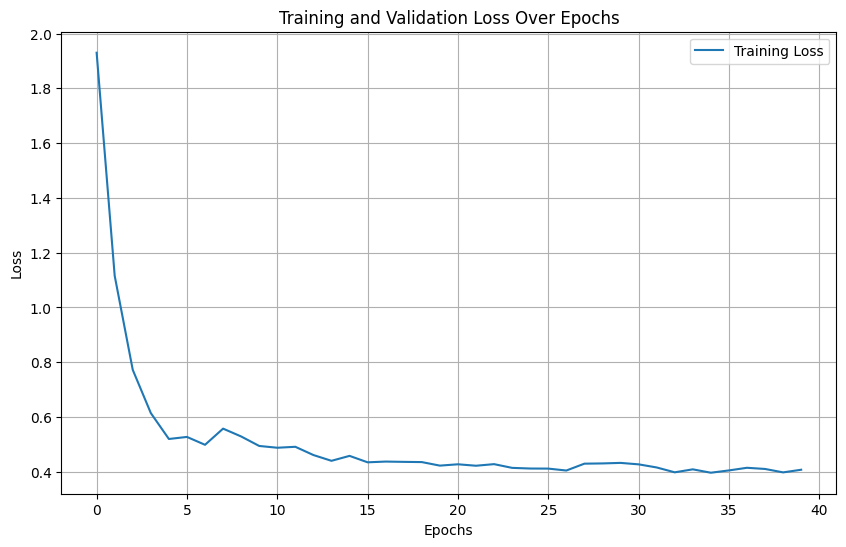

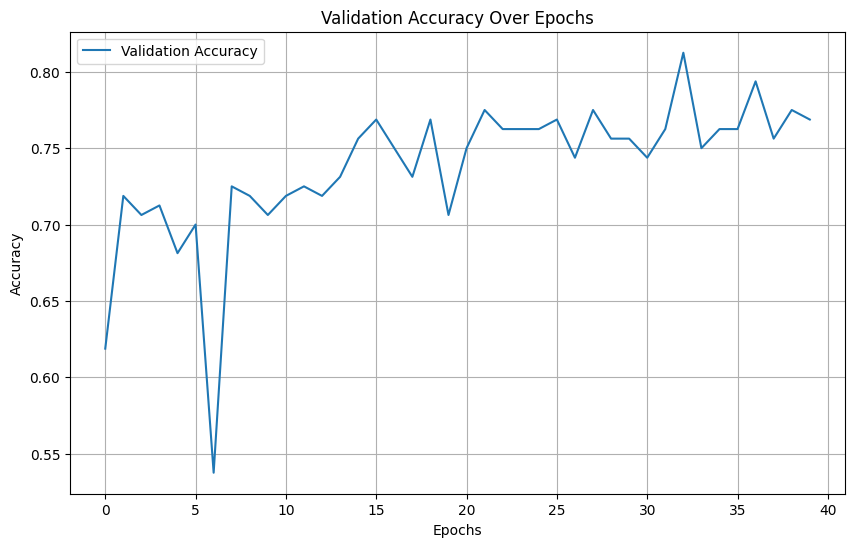

In [122]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and the history is available

# Extract history
history = model.history

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history['val_0_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


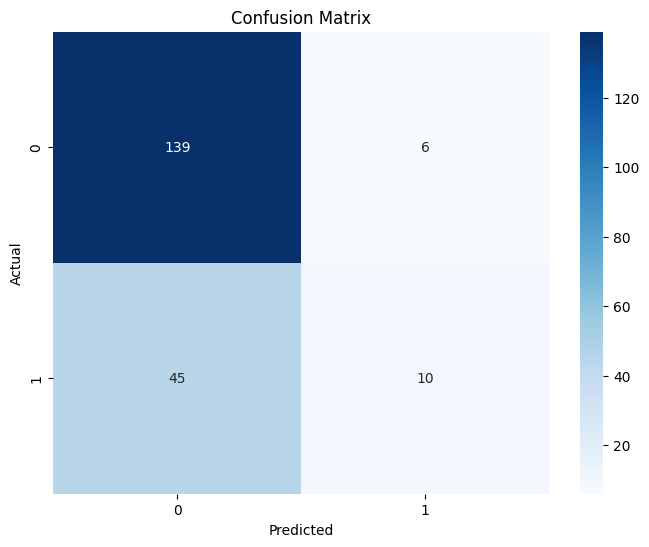

In [121]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test.values)

# Create the confusion matrix
cm = confusion_matrix(y_test.values, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()